In [1]:
import numpy as np
import matplotlib.pyplot as plt
import psycopg2

from datetime import datetime, timezone

### SQL settings

In [2]:
# DBNAME = "fesa_test"
# HOST = "140.181.85.66"
# PORT = "54321"
# USER = "fesa_tester"
# PASSWORD = "save_bpm"

DBNAME = "bpm_fesa_dump"
HOST = "pgsql.gsi.de"
PORT = "8646"
USER = "bpm_fesa_dump_slave"
PASSWORD = "kuwLMKTcAap6mKTP"

In [3]:
try:
    dbcon = psycopg2.connect("dbname="+DBNAME + " user=" + USER + " host=" + HOST + " port=" + PORT + " password=" + PASSWORD)
except Exception as e:
    print("Unable to connect to database")
    print(e)

crsr = dbcon.cursor()

### overview over shots for which all twelve BPMs recorded

In [4]:
def stamp2time(stamp):
    ts = stamp / 1e9
    return datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S.%f')

In [5]:
def fetch_all_acquisitionStamp(crsr=crsr):
    stamps = dict()
    for i in range(1,13):
        bpm_name = "gs{:02d}dx".format(i)
        
        crsr.execute("SELECT acquisitionStamp FROM {} WHERE acqMode = 1;".format("bpm_fesa_dump." + bpm_name + "_acquisition"))
        
        stamps[bpm_name] = crsr.fetchall()
    
    return stamps

In [6]:
def consistent_acquisitionStamp(acquisitionStamps, time_threshold = 1e6):
    consistent_shots = list()  # store all shots for which all twelve BPMs recorded

    gs01dx_arr = np.array(acquisitionStamps["gs01dx"]).squeeze(axis=1)
    for stamp in gs01dx_arr:
        if stamp == 0:
            continue

        shot_stamps = np.zeros((12,), dtype=int)

        for i in range(2,13):
            bpm_name = "gs{:02d}dx".format(i)
            curStamps = np.array(acquisitionStamps[bpm_name]).squeeze(axis=1)

            # closest acquisition
            idx = np.abs(curStamps - stamp).argmin()

            if abs(stamp - curStamps[idx]) > 10:
                # nothing close
                break

            shot_stamps[i-1] = curStamps[idx]
        else:
            shot_stamps[0] = stamp
            consistent_shots.append(shot_stamps)

    consistent_shots = np.stack(consistent_shots)
    
    return consistent_shots

In [7]:
def get_shotOverview(time_threshold = 1e6):
    acquisitionStamps = fetch_all_acquisitionStamp()
    
    return consistent_acquisitionStamp(acquisitionStamps, time_threshold=time_threshold)

In [8]:
shotOverview = get_shotOverview(time_threshold = 1e6)

first_record = shotOverview[0][0]
last_record = shotOverview[-1][0]

print("first record:", stamp2time(first_record))
print("last record:", stamp2time(last_record))

first record: 2023-11-03 10:24:48.970570
last record: 2023-11-07 15:39:04.119730


In [9]:
shotOverview.shape

(658, 12)

In [10]:
all_acquisitionStamp_identical = np.all([
    np.allclose(shotOverview[row,:], shotOverview[row,0]) for row in range(shotOverview.shape[0])
])

if all_acquisitionStamp_identical:
    print("acquisitionStamps identical across all BPMs for each shot")

acquisitionStamps identical across all BPMs for each shot


# Read BPM

In [11]:
date = "2023-11-7"

time = "15:37:28.0"

In [12]:
time_datetime = datetime.strptime(" ".join([date,time]), '%Y-%m-%d %H:%M:%S.%f').replace(tzinfo=timezone.utc)
stamp_given = int(time_datetime.timestamp() * 1e9)

# stamps_arr = np.array(stamps).squeeze(axis=1)
idx_closest_stamp = np.abs(shotOverview[:,0] - stamp_given).argmin()

In [13]:
idx_closest_stamp

626

###### selected cycle

In [14]:
display_stamp = shotOverview[idx_closest_stamp,0]

stamp2time(display_stamp)

'2023-11-07 15:37:27.101850'

# fetch beamPosition for acquisitionStamp

In [15]:
def bpmReadings_demasked(no_bpm: int, acquisitionStamp: int, crsr=crsr):
    statement = """
    SELECT
        processIndex, beamPosition, beamPosition_dim3_labels, processStartStamp
    FROM
        bpm_fesa_dump.gs{:02d}dx_acquisition
    WHERE
        acquisitionStamp = %s
    ORDER BY
        processStartStamp
;
    """.format(no_bpm)
    
    crsr.execute(statement, [int(acquisitionStamp),])
    data = crsr.fetchall()
    
    assert len(data) > 0, "nothing selected"
    
    # flatten over all beamprocesses in this pattern
    x_raw, y_raw, time = list(), list(), list()
    for process in data:
        timepoints = len(process[2])
        time += process[2]
        
        assert 2*timepoints == len(process[1]), "mask assumption wrong"
        
        x = process[1][0:timepoints]
        y = process[1][timepoints:]
        
        x_raw += x
        y_raw += y
        
    return np.array(x_raw), np.array(y_raw), np.array(time)

In [22]:
def findKickTime(x_raw, y_raw, time, harmonic_number: int):
    ######## implement some criterion to locate kick
    
    ##### fake 
    l = 112
    kick_times = time[l:l+harmonic_number]

    # calculate revolution period
    Trev = time[l + harmonic_number] - time[l]
    
    return kick_times, Trev

### fetch

In [23]:
harmonic_number = 4

In [107]:
all_times = list()
trajectory = np.empty((12,3,50024),dtype=np.float128)  # bpm starting from 5, x/y/time, window length

for i, no_bpm in enumerate([5,6,7,8,9,10,11,12,1,2,3,4]):
    x_raw, y_raw, time = bpmReadings_demasked(no_bpm, display_stamp)
        
    if no_bpm == 5:
        kick_times, Trev = findKickTime(x_raw, y_raw, time, harmonic_number)
        print("found kick_times")
        print("Trev", Trev)
        Trev_12 = Trev / 12
        print(Trev_12)

    
    print("\nBPM", no_bpm)
    
    for no_bunch, kickTime in enumerate(kick_times):
        advance = i * 390
        
        retarded_kickTime = kickTime + int(round(advance))
        
        diff = retarded_kickTime - kickTime
        
        assert retarded_kickTime >= kickTime
        
        kick_idx = np.abs(time - retarded_kickTime).argmin()
#         print("kick_idx", kick_idx)
        
        print("minimum distance to retarded_kickTime", np.abs(time - retarded_kickTime).min())
        
        
        traj_mask = np.zeros(time.shape, dtype=bool)
        traj_mask[kick_idx::harmonic_number] = True
        
#         trajectory[i,0,:] = x_raw[traj_mask][:trajectory.shape[2]]
#         trajectory[i,1,:] = y_raw[traj_mask][:trajectory.shape[2]]
#         trajectory[i,2,:] = time[traj_mask][:trajectory.shape[2]]

        trajectory[i,0,:] = x_raw[kick_idx:-1:4][:trajectory.shape[2]]
        trajectory[i,1,:] = y_raw[kick_idx:-1:4][:trajectory.shape[2]]
        trajectory[i,2,:] = time[kick_idx:-1:4][0:trajectory.shape[2]]
        
#         plt.plot(np.diff(time[kick_idx:-1:4][:trajectory.shape[2]]))
#         plt.plot(np.diff(trajectory[i,2,:]))
        all_times.append(time[kick_idx:-1:4][0:trajectory.shape[2]])

found kick_times
Trev 4680
390.0

BPM 5
minimum distance to retarded_kickTime 0
minimum distance to retarded_kickTime 0
minimum distance to retarded_kickTime 0
minimum distance to retarded_kickTime 0

BPM 6
minimum distance to retarded_kickTime 6
minimum distance to retarded_kickTime 6
minimum distance to retarded_kickTime 2
minimum distance to retarded_kickTime 2

BPM 7
minimum distance to retarded_kickTime 4
minimum distance to retarded_kickTime 4
minimum distance to retarded_kickTime 0
minimum distance to retarded_kickTime 0

BPM 8
minimum distance to retarded_kickTime 2
minimum distance to retarded_kickTime 2
minimum distance to retarded_kickTime 2
minimum distance to retarded_kickTime 2

BPM 9
minimum distance to retarded_kickTime 28
minimum distance to retarded_kickTime 32
minimum distance to retarded_kickTime 36
minimum distance to retarded_kickTime 40

BPM 10
minimum distance to retarded_kickTime 26
minimum distance to retarded_kickTime 30
minimum distance to retarded_kickTime 

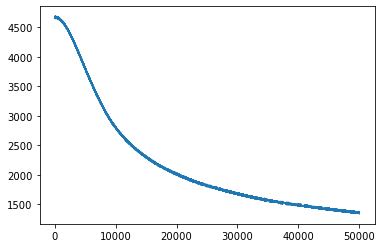

In [105]:
plt.plot(np.diff(all_times[0]))

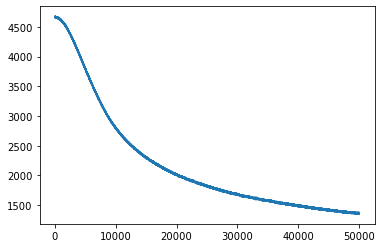

In [106]:
plt.plot(np.diff(trajectory[4,2,:]))

# debug

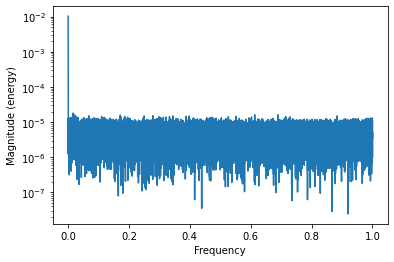

In [111]:
plt.magnitude_spectrum(trajectory[8,0,:])
plt.yscale("log")